#Introduction
The aim of the project is to create a videogame recommender system based on the recommendations provided by users on the Steam platform.

The reasons behind the choice to use Steam are several:


*   Steam is at the moment the biggest videogame store online that also provides a "community mechanic" for their users. The users (that arrives to be 120 million active users each month) have the possibility to create their profile not only to store the games buyed but also to share with their friends the "achievments" that they can get in game and more importantly they have the possiblity to leave reviews on each game on the catalogue in order to communicate their preferences to other users
*   Steam is a highly friendly platform for developer, meaning that they provide APIs to fetch data from their website and also are not against scraping (as long as it compell the robots.txt - http://steamcommunity.com/robots.txt - of the website and is not used in order to create bots to automate transactions, spamming and so on...) meaning that is possible to collect up-to-date data without having too many restrictions
*   If a game is distributed on PCs it will very probable that it will distributed also on Steam; beside some notable exclusive for other online store platform (i.e. Fortnite, Genshin Impact, Minecraft, ...), Steam can be saw as the most comprehensive online store (since it is not tieded to any specific publisher) in which the most of the games for PC can be found


In the following sections I will illustrate the job done in order to create the recommender system. Specifically the following topics will be covered


1.   Dataset Collection
2.   Data Cleaning
3.   Recommendations' Translation
4.   Data Analysis
5.   ALS Training

In the other .ipynb other passages to create the Recommender System will be illustrated. Specifically the following topics will be covered

7.   ALS Model Analysis
8.   Document Clustering over the plot of the games
9.   Clustering Analysis
10.  Demo to try the recommender system






# Needed library import

In this section the needed library to work in the project will be imported. It will also be instantiated some variables whose value will be useful in order to make the computation re-executable

In [ ]:
# In order to make the experiment re-executable
RANDOM_SEED = 42

In [ ]:
# pyngrok is specifically useful in order to make the
# Spark UI visitable for the users
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=a9494f1f9488788bcdd66085d365455100f1dbc798b0492deeda0b285aa45f68
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
# The authtoken is needed to use th ngrok tunnel
!ngrok authtoken 2Tn9uykXlYRjLcSLIgmv1iLdEvG_3gqA9M3V4hLGqH9N3JWEr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# The howlongtobeatpy is the python wrapper for the How Long To Beat API
# that will later be used in the data collection
!pip install howlongtobeatpy

  Preparing metadata (setup.py) ... done
  Created wheel for howlongtobeatpy: filename=howlongtobeatpy-1.0.5-py3-none-any.whl size=10673 sha256=45210bafb4f725377a3cb39457cdf25cc0823849ebaef8381e2d919a0e46821d
  Stored in directory: /root/.cache/pip/wheels/ab/5c/a9/a7ed038bf3e63e09334c66de47707badb6d61bd0d8bd17cbd6
Successfully built howlongtobeatpy


In [ ]:
from pyngrok import ngrok
import os
import re
import requests
import json
import pandas as pd
from tqdm import tqdm
import csv
import time
from bs4 import BeautifulSoup
from howlongtobeatpy import HowLongToBeat
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
%matplotlib inline

#Dataset Collection
In the following section I will explain how I was able to get the dataset needed for the system from the Steam Store.

In order to get the data (as I will explain in a detailed way later) I used the APIs provided by the Store and the platform visited and an ad-hoc web scraper.

## Connection to Google Drive

In [ ]:
# Connect this colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

## Check dataset files presence

In [ ]:
# Checks if the folder in which the dataset is contained is present on Google
# Drive, if it is not present it will proceed with the execution of the scripts
# used to collect the data

# Each flag will check if a specific part of the dataset is present in the
# folder and if not present it will compute that specific part of the dataset
# collection

# This flag is used to check if the file in which the informations about each
# game (either tagged as 'game' or 'DLC') on the store is present
games = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv")
# This flag is used to check if the file in which the informations about the
# users (called 'players' from now on) is present
players = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/players.csv")
# This flag is used to check if the file in which the informations about the
# recommendations (also called 'reviews' from now on) leaved by the players is
# present
game_reviews = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/game_reviews.csv")
# This flag is used to check if the file in which the informations about the
# statistics on the average time used to complete a game is present
hours_stat = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/hours_stat.csv")

### Missing *games.csv* file
If the file containing the informations about the games (either complete games or DLCs) is missing, the following script will be executed.

The script acts as following:


*   Import all the needed libraries
*   Defines the function that is needed to process the response get from the request to the site for the specific game information
* Download the most up-to-date file containing **all** the applications that are present on the store; it is important to notice that not all the application on the store are games (or DLCs), in fact Steam also has listed additional contents for games like soundtracks or artbooks, naturally these items are not interesting for the recommender system so they must be discarded, however the only way to do that is to check for specific informations about the application, see the category of the item and filter them by only maintaining the ones whose category is either *game* or *DLC*
* Saves the information about the interesting items; specifically the script will save the **commercial name** of the application (corresponding to the *name* column in the file), the **appid** of the application which is the **unique identificator** of the application on the store (corresponding to the *steam_appid* column in the file), the **type** of the application (either *game* or *DLC* and corresponding to the *type* column in the file), the **description of the game** provided by the developer/publisher (corresponding to the *about_the_game* column in the file), the **synopsis of the game** (corresponding to the *short_description* column of the file) and the **number of recommendations** that are present on the store for the specific application (corresponding to the *total_recommendation* column in the file). As for the recommendations is important to notice that the value could not be the same as the one that actually is on the store (meaning that there could be some games that have on the file **less** reviews than the one that are actually on the store): this is due to a limitation of the API that only get the reviews that has been written in the past 365 days from the day in which the request is made (so as it will be described later, in order to get the most of the reviews the API has not been used in favor of an ad-hoc scraper that actually is able to get more reviews)
* Perform a preliminary cleaning of the data: when retrieved from the store in fact the textual data about the game (stored in both the column *about_the_game* and *short_description*) is not ready to be stored in a .csv file; the text is in fact full of characters (like HTML tags, tabs, newlines, commas, semicolons or pipes) that could cause problems in the formatting of the file, so in order to have the file only with the wanted columns is necessary to filter them before saving it



In [ ]:
if not games:
  def get_game_info(app_id):
    """
    This function takes the app_id of a game and returns the information
    about the game from the Steam API.
    """
    url = f'http://store.steampowered.com/api/appdetails?appids={app_id}'
    try:
      response = requests.get(url)
    except:
      with open('output_files/error_log.csv', 'a') as F_err:
        writer = csv.writer(F_err)
        writer.writerow([app_id])
      return {}
    data = response.json()
    # The data could be None if the time-limit amount of requests
    # given by the API is exceeded
    if data == None:
      with open('output_files/error_log.csv', 'a') as F_err:
        writer = csv.writer(F_err)
        writer.writerow([app_id])
      return {}
    # The success of the request can be True if the application is public
    # and has information to be read or False if the application cannot be
    # saw by users and so it does not have public information to be read
    if data[str(app_id)]['success']:
      return data[str(app_id)]['data']
    else:
      return {}


  # This framework is useful in case of the freeze of the script due to possible
  # errors: since new applications are added to the store very frequently, it is
  # useful to define the set of the applications to be checked to a specific
  # AppList downloaded at the beginning of the dataset collection

  # Check for the existence of the Steam application file
  # If not present, download it
  # CONTROLLA POI STA COSA DI OUTPUT_FILES
  if not os.path.exists('output_files/apps.csv'):
    print('Steam application file not found. Downloading it...')
    URL = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    # In this case the try-except is not needed because this file is always
    # downloadable
    r = requests.get(url=URL)
    apps_data = r.json()
    # CONTROLLA QUALI SONO GLI ALTRI CAMPI DEL FILE JSON
    apps_data = apps_data['applist']['apps']
    with open('output_files/apps.json', 'w') as F:
        json.dump(apps_data, F)
    # The file is then converted to json and then to csv in order to have a
    # more friendly usable file
    df = pd.read_json('output_files/apps.json')
    df.to_csv('output_files/apps.csv', index=None)
  else:
    print('Steam application file found. Loading it...')


  # Read the Steam application file as dataframe
  # and get only the identifier of the applications
  df = pd.read_csv('output_files/apps.csv')
  app_ids = df['appid']

  # Checks if the file containing the needed information about the partial dataset
  # is present; if not create it
  if not os.path.exists('output_files/games.csv'):
    with open('output_files/games.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['name', 'steam_appid', 'type', 'about_the_game', 'short_description', 'total_recommendations', ]
      writer.writerow(cols)

  # Same as before, but the 'other.csv' file will contain all the applications that
  # are not games or DLCs
  if not os.path.exists('output_files/other.csv'):
    with open('output_files/other.csv', 'w') as F_1:
      writer_1 = csv.writer(F_1)
      cols = ['steam_appid']
      writer_1.writerow(cols)

  # Loop over the entire list of application to find games and DLCs
  for i, row in tqdm(app_ids.to_frame().iterrows(), total = app_ids.shape[0]):
    # This sleep is needed to avoid the overcame of the time-limit of the API
      if i%20 == 0:
          time.sleep(15)
      app_id = row['appid']
      game_info = get_game_info(app_id)
      if game_info != {}:
        # get only the needed informations
          if game_info['type'] == 'game' or game_info['type'] == 'dlc':
              data = []
              data.append(game_info['name'])
              data.append(game_info['steam_appid'])
              data.append(game_info['type'])
              data.append(game_info['about_the_game'])
              data.append(game_info['short_description'])
              try:
                  data.append(game_info['recommendations']['total'])
              # this could happen both because no reviews were left for the game
              # or because no reviews were left for the game in the past 365
              # days
              except KeyError:
                  data.append(0)
              with open('output_files/games.csv', 'a') as F:
                writer = csv.writer(F)
                writer.writerow(data)
          else:
            with open('output_files/other.csv', 'a') as F_1:
              writer_1 = csv.writer(F_1)
              writer_1.writerow([app_id])
      else:
        with open('output_files/other.csv', 'a') as F_1:
          writer_1 = csv.writer(F_1)
          writer_1.writerow([app_id])

  # Needed clean in order to correctly format the csv file
  def clean_html(raw_html):
    """
    This function is used to delete the HTML tags and their content from the text
    thanks to the CLEANER_TAGS regex
    """
    # This is a regex needed to remove HTML tags from the texts
    CLEANER_TAGS = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANER_TAGS, '', raw_html)
    return cleantext

  def clean_separators(raw_text):
    """
    This function is used to delete the charachters that are used as csv
    separators thanks to the CLEANER_SEPARATORS regex
    """
    # This is a regex needed to remove all the characters that could be read as
    # separators in the .csv file
    CLEANER_SEPARATORS = re.compile(r'[,\t;|]')
    cleanedtext = re.sub(CLEANER_SEPARATORS, '', raw_text)
    return cleanedtext

  def format_string(raw_text):
    """
    This function is needed to remove all the multiple whitespaces in the text
    """
    return ' '.join(raw_text.split())

  games_df = pd.read_csv("/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv")

  games_df['name'] = games_df['name'].astype(str)
  games_df['name'] = games_df['name'].apply(clean_separators)
  games_df['name'] = games_df['name'].apply(format_string)

  games_df['about_the_game'] = games_df['about_the_game'].astype(str)
  games_df['about_the_game'] = games_df['about_the_game'].apply(clean_html)
  games_df['about_the_game'] = games_df['about_the_game'].apply(clean_separators)
  games_df['about_the_game'] = games_df['about_the_game'].apply(format_string)

  games_df['short_description'] = games_df['short_description'].astype(str)
  games_df['short_description'] = games_df['short_description'].apply(clean_html)
  games_df['short_description'] = games_df['short_description'].apply(clean_separators)
  games_df['short_description'] = games_df['short_description'].apply(format_string)

  games_df = games_df[['name', 'steam_appid', 'type', 'about_the_game', 'short_description', 'total_recommendations']]

  games_df.to_csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv', index=False)

else:
  print("'games.csv' file found")

'games.csv' file found


### Missing *players.csv* file
If the file containing the informations about the games (either complete games or DLCs) is missing, the following script will be executed.

The script acts as following:


*   At first imports all the needed libraries
*   Then filters the games collected before by getting only the ones for which the *total_recommendation* column in the file *games.csv* has at least 1 recommendation (as said before this could not get all the games that have at least one recommendation due to the year-limit of the API but this limit will be overcome later during the collection of the reviews that will be done starting from the players and not from the games)
* Then for each one of the games filtered the script will try to get the **first 100 players** by retrieving the **100 most valuable reviews** for the game. The Steam store in fact gives the possibility to the user to judge the reviews left by other players by voting them as *useful* or *not useful*. By providing the request made in the script the API will return as result at most the first 100 reviews that were also judged as the most useful for the game. This decision has been made in order to avoid troll reviews or reviews done for review bombing which are pretty common in Steam
* The Steam identification numbers of the players are then saved in the *players.csv* file



In [ ]:
if not players:
  # Filter to get only the games that in the last year have been reviewed at
  # least one time
  df = pd.read_csv('output_files/games.csv')
  df_tmp = df[df['total_recommendations']>0]
  app_ids = df_tmp['steam_appid'].tolist()


  # Prepare to save the players, it is important to use a set because it is
  # important to not have duplicated users from which the reviews will be
  # later retrieved
  players = set()


  # This framework is used to make the script robust to errors and to possible
  # re-execution.
  # The script first checks if some players were already found, if not it will
  # create the file to save their ids
  if not os.path.exists('output_files/players.csv'):
    print("No players found.")
    with open('output_files/players.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['steam_id', ]
      writer.writerow(cols)
  # If some players were already saved then the starting set is set to the
  # ids that were previously collected
  else:
    print("Some players found, ids loaded.")
    df_players = pd.read_csv('output_files/players.csv')
    players = set(df_players['steam_id'].tolist())

  # This file is used to collect possible games whose resolution is not
  # successful and it is mostly used to have an hint of the 'health' of the
  # current execution of the script and so is created at any execution of the
  # script
  with open('output_files/error_appid.csv', 'w') as F_1:
    writer_1 = csv.writer(F_1)
    cols = ['steam_appid', ]
    writer_1.writerow(cols)

  # This file collects the games for which the 100 most valuable players have
  # been collected, since the script must be resilient to error and re-executions
  # at any new execution the script will check for its existence and if the file
  # is not found it will create it
  if not os.path.exists('output_files/resolved_appid.csv'):
    print('No resolved ids found.')
    with open('output_files/resolved_appid.csv', 'w') as F_2:
      writer_2 = csv.writer(F_2)
      cols = ['steam_appid', ]
      writer_2.writerow(cols)
  # Naturally if the file is found it means that some games were already resolved
  # and in order to not make duplicate requests the appids of the resolved
  # applications are removed from the list of the applications that must be
  # resolved in the execution
  else:
    print('Already resolved some games ids, removing them from the list...')
    df_resolved = pd.read_csv('output_files/resolved_appid.csv')
    resolved_app_ids = df_resolved['steam_appid'].tolist()
    app_ids = list(set(app_ids) - set(resolved_app_ids))


  # Loops over all the appids that must be resolved
  for app_id in tqdm(app_ids, total=len(app_ids)):
    # Try to get the 100 most valuable reviews (and following the 100 most
    # valuable users that have written those reviews)
    url = f'https://store.steampowered.com/appreviews/{app_id}?json=1&language=all&num_per_page=100'
    # This sleep is needed in order to not exceed the time-limit imposed by the
    # API
    time.sleep(1)
    try:
      response = requests.get(url)
    except:
      with open('output_files/error_appid.csv', 'a') as F_1:
        writer_1 = csv.writer(F)
        writer.writerow([app_id])
        continue
    if response.status_code == 200:
      data = response.json()
      # If the request is successfull for each review the script saves the
      # player id
      with open('output_files/players.csv', 'a') as F:
        writer = csv.writer(F)
        for review in data['reviews']:
          player_id = review['author']['steamid']
          if player_id not in players:
            players.add(player_id)
            writer.writerow([player_id])
      # And save the appid as one that has been resolved
      with open('output_files/resolved_appid.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([app_id])
    else:
      with open('output_files/error_appid.csv', 'a') as F_1:
        writer_1 = csv.writer(F_1)
        writer_1.writerow([app_id])
else:
  print("'players.csv' file found")

'players.csv' file found


### Missing *games_reviews.csv* file
After getting all the players interesting for the system it's time to collect the reviews that they wrote.
The aim of the project is to create a **Collaborative Filtering Recommender System** and for this reason is important to collect the reviews not much for the specific items that the system will recommend but moreover for the specific users of the system that will later on be used in order to compute the similarities among the user that wants the recommendation and the ones that are collected in the system.
The Steam APIs (in addition of not having the possibility to check for reviews older than 1 year from the request - which can be naturally a big problem since, excluding some games that are continuously consumed by new users, games are usally reviewed only in the few following months from the publishing) does not actually give the possibility to get the reviews starting from the users.
In order to overcome this two big limitation an ad-hoc scraper has been created.

The script used to retrieve the games review starting from the users acts as following:


*   Import all the needed libraries
*   Define the function that is used, given a Steam id for an user and a page number indicating a page of their *review section* on their Steam profile, to parse the HTML page got as response of the request and save **only** the reviews from the response
*   Retrieve the previously found players
*   For each one of the found players, the script will get all the reviews written by the players together with the needed information got from the reivew


It is important to notice that the saved information for each review are: **Steam id of the author** (corresponding to the *steam_id* column in the file), the **Application id for which the review has been written** (corresponding to the *app_id* column in the file), the **recommendation** given by the user for the application (can either be *Recommended* or *Not Recommended* and it's corresponding to the *recommended* column in the file) and the **amount of hours for which the user has played the game** (can be not present or present with two different values corresponding to the **total amount of time for which the user has been playing the game** and the **total amount of time for which the user has played the game at the moment of the writing of the review**; this data corresponds to the *hours_played* in the file).
There are two important aspects that deserve to be mentioned: the first one is that it has been decided to not take in consideration the textual feedback given by the users; this is because the textual feedback is not actually mandatory in order to submit a review for a game and also because even if present the textual feedback can be actually unusefull in order to understand the feeling of the user towards the game (since it can be composed by emoticons or ASCII drawings). The second one is strictly connected to the aspect just mentioned: as already said the recommendations on Steam can only be categorized as *Recommended* or *Not Recommended* meaning the user cannot express **how much** they recommend or not a game; it's in this situation that the **hours that players spent playing the games** are helpful: by having an idea of **how much is the average time to complete a game** (which will be later explained) it is possible to convert the simple recommendation on a larger scale of grades (by taking in account how much time they spent before writing the review, if they continued playing the game after that and so on...). Naturally not all the reviews are connected to the play-time of the users (since it's possible to play the games without having Steam collecting the user data about the gaming experience), in this case the reviews will be considered *neutral with a positive (or negative) meaning*.




In [ ]:
if not game_reviews:
  # Define the function needed to retrieve all the reviews written by an user
  # and found in a specific page of the review section of their profile
  def get_reviews(steam_id, page_number):
    """
    This function parse the given page page_number for the review section of the
    of the user profile with steam_id identification number. From the page it
    returns the list of all the reviews in page (all characterized by the tag
    <class='review_box'> in the HTML page)
    """
    url = f"https://steamcommunity.com/profiles/{steam_id}/recommended/?p={page_number}"
    # The user agent is defined in order to avoid to be recognized as a Python
    # bot by the website
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    reviews = soup.findAll('div', {'class': 'review_box'})
    return reviews


  # Get all the previously found players
  df_players = pd.read_csv('output_files/players.csv')
  steam_ids = set(df_players['steam_id'].tolist())


  # This framework is used in order to make the script resilient to errors and
  # re-execution
  # Specifically at any execution it will check if the file containing the reviews
  # is present; if not it will create it
  if not os.path.exists('output_files/game_reviews.csv'):
    print("Creating review file...")
    with open('output_files/game_reviews.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['steam_id', 'app_id', 'recommended', 'hours_played']
      writer.writerow(cols)
  # If it is present the reviews will be appended to the pratial result
  else:
    print("Review file found, next reviews will be appended")

  # As before the error file is used to have an hint of the 'health' of the
  # execution and to store all the users ids for which the retrieving of the
  # reviews has not worked.
  # Since the error file is not used to successfully resume execution after an
  # interruption the file is created brand new at any execution
  with open('output_files/error_steam_ids.csv', 'w') as F_1:
    writer_1 = csv.writer(F_1)
    cols = ['steam_id']
    writer_1.writerow(cols)

  # As before it is important to save the resolved user for which the reviews
  # has already been collected, so it is important to have a file that stores
  # all the resolved users, the script will check at any execution if the file is
  # present: if not it will create it
  if not os.path.exists('output_files/resolved_steam_ids.csv'):
    print("No resolved steam ids found.")
    with open('output_files/resolved_steam_ids.csv', 'w') as F_2:
      writer = csv.writer(F_2)
      cols = ['steam_id']
      writer.writerow(cols)
  # If not present the alreay resolved users will be deleted from the ones that
  # must be resolved.
  # It is important to notice that this framework limits the duplication in case
  # of abruption of the script: in fact the worst case is the one for which the
  # script interrupts while having resolved some but not all the reviews for a user.
  # In this case at the following execution of the script that user will be again
  # resolved and some of the reviews will be duplicated but they can be easily
  # removed later
  else:
    print("Some resolved steam ids found, ids loaded.")
    df_resolved = pd.read_csv('output_files/resolved_steam_ids.csv')
    resolved_steam_ids = df_resolved['steam_id'].tolist()
    steam_ids = list(set(steam_ids) - set(resolved_steam_ids))


  # Loops for each user that must be resolved
  for steam_id in tqdm(steam_ids, total=len(steam_ids)):
    # i is a counter that show at which page of the 'reviews' section of the
    # profile of a specific user the script has arrived; it is important to
    # notice that the pages will always start from 1 and goes on up until all
    # the reviews has been showed
    # When analyzing a new user the page counter is set to 0
    i = 0
    # This sleep is used to wait a bit before processing a new user, in this
    # way the Steam website will never be overflooded by requests and the
    # scraping won't go against the terms of usage
    time.sleep(1.5)
    # Up until is possible to find more reviews
    while True:
      # The script will analyze a new page of the 'review' section of the profile
      i += 1
      try:
        reviews = get_reviews(steam_id, i)
      except:
        with open('output_files/error_steam_ids.csv', 'a') as F_1:
          writer_1 = csv.writer(F_1)
          writer_1.writerow([steam_id])
          break
      # If some reviews are found
      # This check is useful because for each user is possible to check any page
      # wanted to be checked from the 'review' section of the profile but if the
      # user did not wrote as much reviews needed to complete all the previous
      # pages the list returned by the parser will be empty
      if reviews != []:
          # For each review written by the user collect all the needed informations
          for review in reviews:
            review_data = []
            # The author of the review
            review_data.append(str(steam_id))
            # The steam application id: in the section of the HTML page
            # characterized by the tag <class='game_capsule_ctn'> is present a
            # picture representing the thumbnail of the game, the image is linked
            # to the application page on the Steam store and so it is possible
            # to get from the link the Steam appid of the application.
            # All the links have the following structure
              # https://steamcommunity.com/app/{app_id}
            # and so the app_id can be found starting from the character present
            # in the position 31 of the string up until the end of the link
            app_id = review.find('a', {'class': 'game_capsule_ctn'})['href'][31:]
            review_data.append(app_id)
            # The value for the recommendation of the review
            recommended = review.find('div', {'class': 'title'}).text
            review_data.append(recommended)
            # The amount of hours played by the user for the game
            hours_played = review.find('div', {'class': 'hours'}).text
            hours_played = hours_played.replace('\r', '')
            hours_played = hours_played.replace('\n', '')
            hours_played = hours_played.replace('\t', '')
            review_data.append(hours_played)
            # Then save the information for the review
            with open('output_files/game_reviews.csv', 'a') as F:
              writer = csv.writer(F)
              writer.writerow(review_data)
      # When no more new pages with reviews can be found than the user can be
      # considered resolved
      else:
        with open('output_files/resolved_steam_ids.csv', 'a') as F_2:
          writer_2 = csv.writer(F_2)
          writer_2.writerow([steam_id])
          break


  # After getting all the reviews is important to maintain only the ones about
  # the apps that are in the 'games.csv' since it could happen that there are
  # some reviews about games that are not in the total lists of game that the
  # recommender system is considering
  df_rev = pd.read_csv('output_files/game_reviews.csv')
  df_game = pd.read_csv('output_files/games.csv')

  df_game = df_game[['name', 'steam_appid']]
  df_rev = df_rev[df_rev['app_id'].isin(df_game['steam_appid'])]
  df_rev.to_csv('output_files/game_reviews.csv', index=False)
else:
  print("'game_reviews.csv' file found")

'game_reviews.csv' file found


### Missing *hours_stat.csv* file
As already mentioned in order to get the *rating* of a review written by an user is important to know the average time needed to complete a game (in this way it's possible to compare how many hours the played the game and understand if the user had a complete knowledge about the game in order to express the recommendation). Since knowing how long a game is it has always been an important notion for gamers, there is a portal, called *howlongtobeat* that provide the amount of time (estimated from the data given by the user of the platform) that is needed to complete a game.
How Long To Beat actually provides at most 4 different possible values: the amount of time needed to **complete the main storyline**, the amount of time needed to **complete the main storyline and the extra-quests**, the amount of time needed to **complete the game at 100%** (with all the secrets) and the amount of time used by a **casual gamer wihtout any specific objectives**.
It is importat to understand though that not all the games present on Steam are also listed on HLTB (since Steam is full of indie games that are not widely played)

In order to retrieve the data from the website the API has been used. The script used to retrive the needed data acts as following:


*   Imports all the needed libraries
*   Filters all the games for which is present at least one review
*   Creates a connection to the How Long To Beat portal and retrieves all the wanted information from the portal



In [ ]:
if not hours_stat:
  # Filter all the games for which there is a review in the dataset
  df_game = pd.read_csv('output_files/games.csv')
  df_rev = pd.read_csv('output_files/game_reviews.csv')
  df_game = df_game[df_game['steam_appid'].isin(df_rev['app_id'])]
  df_game = df_game.dropna(subset=['name'])

  # Create a dictionary with interesting information about games to be saved later
  game_dict = dict(zip(df_game['name'], df_game['steam_appid']))
  # Retrieve all the titles of the interesting games
  titles = game_dict.keys()

  # This framework is used to make the script resilient to errors and re-executions
  # Since if for a game the information has already been collected it must not
  # be analyzed again the script check at any execution if the file that stores
  # the resolved games exists; if not it will create it, if present it will remove
  # the resolved games from the ones that must be resolved
  if os.path.exists('output_files/resolved_games.csv'):
    print('Already resolved some titles, removing them from the list...')
    resolved_df = pd.read_csv('output_files/resolved_games.csv')
    resolved_titles = resolved_df['title'].tolist()
    titles = list(set(titles) - set(resolved_titles))
  else:
    print('No resolved games yet, starting from the beginning...')
    with open('output_files/hours_stat.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['title', 'steam_appid', 'main_story', 'main_extra', 'complesionist', 'all_styles', ]
      writer.writerow(cols)
    with open('output_files/resolved_games.csv', 'w') as F_1:
      writer_1 = csv.writer(F_1)
      writer_1.writerow(['title'])
  with open('output_files/unresolved_games.csv', 'w') as F_2:
      writer_2 = csv.writer(F_2)
      writer_2.writerow(['title'])


  # It creates a connection with the How Long To Beat API
  hltb = HowLongToBeat()
  # Loops over all the needed games
  for title in tqdm(titles, total=len(titles)):
    app_id = game_dict[title]
    try:
      results = hltb.search(title)
    except:
      with open('output_files/unresolved_games.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([title])
    # If the request on the site is successfull and the game is on the platform
    # it collects the hours statistics for each 'game style'
    if results != None:
      if len(results) > 0:
        game = results[0]
        data = []
        data.append(title)
        data.append(app_id)
        data.append(game.main_story)
        data.append(game.main_extra)
        data.append(game.completionist)
        data.append(game.all_styles)
      # If the game is not present on the platform all the statistics will be
      # set to 0
      else:
        data = []
        data.append(title)
        data.append(app_id)
        data.append(0)
        data.append(0)
        data.append(0)
        data.append(0)
      # The statistics will be saved
      with open('output_files/hours_stat.csv', 'a') as F:
        writer = csv.writer(F)
        writer.writerow(data)
      # And the game will considered resolved
      with open('output_files/resolved_games.csv', 'a') as F_1:
        writer_1 = csv.writer(F_1)
        writer_1.writerow([title])
    else:
      with open('output_files/unresolved_games.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([title])
else:
  print("'hours_stat.csv' file found")

'hours_stat.csv' file found


#PySpark Initialization

Since the project will be over a large amount of data is pretty much useful to use Pyspark in order to manage the data (and later on the models). In this section the session to the Pyspark framework will be initializated.

In [ ]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=ad58122374ee3031ac0975b1131552689244949ed54ff0256eddb9e7ef80631c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Import libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
# It is important to notice that in order to make use later on of Python functions
# like min and max is necessary to rename the Pyspark.sql functions that would
# otherwise override the Python functions
from pyspark.sql import functions as sqlf
from pyspark import SparkContext, SparkConf
# This libraries will later on be used to train the Collaborative Filtering
# model
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set('setCheckpointDir', '/content/gdrive/MyDrive/VideogameRecommenderSystem/checkpoints_pyspark').\
                setAppName("VideogameRecommenderSystem").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
# This is needed to expose publicly the ngrok tunnel to the Spark UI
port = '4050'
public_url = ngrok.connect(port).public_url

In [ ]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://173e-34-74-255-57.ngrok-free.app" -> "http://127.0.0.1:4050"


In [ ]:
# To check if the Spark session has been correctly started
spark

#Data Cleaning
In the following section I will explain in detail the job done in order to clean the data collected.

Specifically each table has been cleaned in order to have the data pre-processed and ready to be used for further operations.

##*games.csv* cleaning
In this section is presented the pre-eliminary work done to clean the games.csv table (that will be later on be re-done in order to pre-process the data for the document clustering).

In [ ]:
# Load the needed data
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
# Present the structure of the data
print("Row number:", games_df.count(), "\nColumn number:", len(games_df.columns))

Row number: 131974 
Column number: 6


In [ ]:
# Check for the columns in the table
games_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- total_recommendations: integer (nullable = true)



Since the data will later on be used for clustering is important to remove rows for which the plot of the game has not been collected. In order to achieve this it is important to inspect if there are some NaNs value on important columns and, if the rows are not too much, remove them

In [ ]:
# show nans (count rows if there are no nans)
games_df.summary('count').show()

+-------+------+-----------+------+--------------+-----------------+---------------------+
|summary|  name|steam_appid|  type|about_the_game|short_description|total_recommendations|
+-------+------+-----------+------+--------------+-----------------+---------------------+
|  count|131974|     131974|131974|        131884|           131974|               131974|
+-------+------+-----------+------+--------------+-----------------+---------------------+



As it can be saw from the previous table there are only 90 rows that do not present a value for the column *about_the_game*. Since it's a very conspicuous number they can be removed without problems

In [ ]:
print("Row number before excluding rows with NaNs:", games_df.count())

Row number before excluding rows with NaNs: 131974


In [ ]:
# remove rows with nans
games_df = games_df.dropna()
print("Row number after excluding rows with NaNs:", games_df.count())

Row number after excluding rows with NaNs: 131884


As it can be saw from the row sample presented, inside the textual representation of the plots of the games sometimes links are present.

Since the cannot provide useful information about the actual plot of the game (they are either links to the game page or links to some images) they can be removed without any loss for the information

In [ ]:
# Inspect some rows of the table
games_df.show(n=5, truncate=False)

+----------------------------------------+-----------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Remove the links from the games descriptions since they are not relevant for
# the project
def clean_links(raw_text):
  """
  This function is used to remove all the links from the texts thanks to the
  CLEANER_LINKS regex
  """
  CLEANER_LINKS = re.compile('http[s]?://\S+')
  cleantext = re.sub(CLEANER_LINKS, '', raw_text)
  return cleantext

In [ ]:
# It has been chosen to create an UDF (User Defined Function) in order to have
# the possibility to use the function to clean links (that must be applied to)
# each row of the datarame with the PySpark withColumn function
clean_links_UDF = sqlf.udf(lambda x : clean_links(x), StringType())

In [ ]:
def clean_row(dataset_df, columnName):
  """
  This function is used to perform cleaning on the wanted column of the dataframe.
  Specifically the function deletes the links from the column and then checks
  (and removes) if the deletion of the links comported the appearance of any
  whitespaces at the beginning or at the end of the text
  """
  dataset_df = dataset_df.withColumn(columnName, clean_links_UDF(sqlf.col(columnName)))
  dataset_df = dataset_df.withColumn(columnName, sqlf.trim(sqlf.col(columnName)))
  return dataset_df

In [ ]:
games_df = clean_row(games_df, 'about_the_game')
games_df = clean_row(games_df, 'short_description')

In [ ]:
# Show the previous sample of rows to check if the links were correctly removed
games_df.show(n=5, truncate=False)

+----------------------------------------+-----------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##*game_reviews.csv* cleaning
In this section is presented the pre-eliminary work done to clean the games_reviews.csv table.
Specifically in this section it will be presented how it was possible to retrieve the amount of time played by the user that wrote the review from the text that was collected during the data collection

In [ ]:
# Load the needed data
reviews_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/game_reviews.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
# Check for the data structure
print("Row number:", reviews_df.count(), "\nColumn number:", len(reviews_df.columns))

Row number: 6788734 
Column number: 4


In [ ]:
# Check for the columns of the table
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)



In [ ]:
# Check if there are some NaNs
reviews_df.summary('count').show()

+-------+--------+-------+-----------+------------+
|summary|steam_id| app_id|recommended|hours_played|
+-------+--------+-------+-----------+------------+
|  count| 6788734|6788734|    6788734|     6788734|
+-------+--------+-------+-----------+------------+



As it can be saw from the following table the data about the amount of hours played by each user is not ready to be used for further computations: it is merealy a string that present the information that needs to be splitted into two different columns *total_played_hours* and *played_hours_on_review* each one containing the float representation of the amount of time for each user played the game

In [ ]:
# Inspect a sample of rows
reviews_df.show(n=10, truncate=False)

+-----------------+-------+---------------+-----------------------------------------------+
|steam_id         |app_id |recommended    |hours_played                                   |
+-----------------+-------+---------------+-----------------------------------------------+
|76561198832156672|277739 |Not Recommended|0.0 hrs on record                              |
|76561198850506752|960990 |Recommended    |13.3 hrs on record(13.3 hrs at review time)    |
|76561198850506752|1987080|Recommended    |8.1 hrs on record(4.0 hrs at review time)      |
|76561198850506752|240    |Recommended    |43.0 hrs on record                             |
|76561198850506752|620    |Recommended    |16.5 hrs on record(5.6 hrs at review time)     |
|76561198850506752|730    |Recommended    |1,102.3 hrs on record(307.2 hrs at review time)|
|76561198850506752|381210 |Recommended    |444.0 hrs on record(127.8 hrs at review time)  |
|76561198046773252|200910 |Recommended    |16.3 hrs on record                   

In [ ]:
def create_tot_hours(raw_text):
  """
  This function is used to parse the textual information about the hours played
  by the users thanks to the CLEANER_CHARACTERS regex that is used to only
  maintain the numerical information in the string. Specifically this function
  is used to compute the the informations about the total hours played (which is
  an information that is always present)
  """
  CLEANER_CHARACTERS = re.compile(r'[(),a-zA-Z]')
  cleanedtext = re.sub(CLEANER_CHARACTERS, '', raw_text)
  tmp = cleanedtext.split()
  tot = float(tmp[0])
  return tot

def create_hours_on_review(raw_text):
  """
  This function is used to parse the textual information about the hours played
  by the users thanks to the CLEANER_CHARACTERS regex that is used to only
  maintain the numerical information in the string. Specifically this function
  is used to compute the the informations about the hours played when the player
  wrote the review (which is an information that is not always present; in case
  of the missing information 0.0 will be stored as the played time on review)
  """
  CLEANER_CHARACTERS = re.compile(r'[(),a-zA-Z]')
  cleanedtext = re.sub(CLEANER_CHARACTERS, '', raw_text)
  tmp = cleanedtext.split()
  tot = 0.0
  if len(tmp) == 2:
    tot = float(tmp[1])
  return tot

In [ ]:
# As before the UDF about the previous defined functions were created
create_tot_hours_UDF = sqlf.udf(lambda x : create_tot_hours(x), FloatType())
create_hours_on_review_UDF = sqlf.udf(lambda x : create_hours_on_review(x), FloatType())

In [ ]:
def create_played_hours_information(dataset_df, columnName='hours_played'):
  """
  This function is used to create the numerical information about the hours that
  each player played for each game that they reviewed both for the total played
  hours and for the hours played at the moment of the review
  """
  dataset_df = dataset_df.withColumn('total_played_hours', create_tot_hours_UDF(sqlf.col(columnName)))
  dataset_df = dataset_df.withColumn('played_hours_on_review', create_hours_on_review_UDF(sqlf.col(columnName)))
  return dataset_df

In [ ]:
reviews_df = create_played_hours_information(reviews_df)
# This renaming is useful in order to have all the tables with the column named
# in the same way
reviews_df = reviews_df.withColumnRenamed('app_id', 'steam_appid')

In [ ]:
# Check if the job done on the columns got to the wanted result
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)
 |-- total_played_hours: float (nullable = true)
 |-- played_hours_on_review: float (nullable = true)



As it can be saw from the follwoing table the parsing of the information about the amount of hours played by the player has been correctly done

In [ ]:
# Inspect a sample of rows
reviews_df.show(n=10, truncate=False)

+-----------------+-----------+---------------+-----------------------------------------------+------------------+----------------------+
|steam_id         |steam_appid|recommended    |hours_played                                   |total_played_hours|played_hours_on_review|
+-----------------+-----------+---------------+-----------------------------------------------+------------------+----------------------+
|76561198832156672|277739     |Not Recommended|0.0 hrs on record                              |0.0               |0.0                   |
|76561198850506752|960990     |Recommended    |13.3 hrs on record(13.3 hrs at review time)    |13.3              |13.3                  |
|76561198850506752|1987080    |Recommended    |8.1 hrs on record(4.0 hrs at review time)      |8.1               |4.0                   |
|76561198850506752|240        |Recommended    |43.0 hrs on record                             |43.0              |0.0                   |
|76561198850506752|620        |Rec

## *hours_stat.csv* cleaning
In this section it will be presented the work done to clean the hours_stat.csv table. This table will not need a big cleaning but in order to optimize the amount of data that needs to be maintain in memory, the unuseful columns will be removed.

In [ ]:
# Load the needed data
hours_stat_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/hours_stat.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
# Check for the data structure
print("Row number:", hours_stat_df.count(), "\nColumn number:", len(hours_stat_df.columns))

Row number: 79977 
Column number: 6


In [ ]:
# Check for the columns in the table
hours_stat_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- steam_appid: string (nullable = true)
 |-- main_story: string (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



As it can be saw from the column schema of the table, there are two columns that are not in the wanted fromat: specifically the *steam_appid* column, that is a string instead of an integer, and the *main_story* column, that is a string instead of a double.

So, in order to have a consistency among data that will have hte need to interact together, it is necessary to cast this two columns to the wanted data type

In [ ]:
hours_stat_df = hours_stat_df.withColumn('steam_appid', hours_stat_df.steam_appid.cast('integer'))
hours_stat_df = hours_stat_df.withColumn('main_story', hours_stat_df.main_story.cast('double'))

In [ ]:
# Check if there are some NaNs
hours_stat_df.summary('count').show()

+-------+-----+-----------+----------+----------+-------------+----------+
|summary|title|steam_appid|main_story|main_extra|completionist|all_styles|
+-------+-----+-----------+----------+----------+-------------+----------+
|  count|79977|      79977|     79977|     79977|        79977|     79977|
+-------+-----+-----------+----------+----------+-------------+----------+



In [ ]:
# Inspect a sample of rows
hours_stat_df.show(n=5, truncate=False)

+---------------------------------------+-----------+----------+----------+-------------+----------+
|title                                  |steam_appid|main_story|main_extra|completionist|all_styles|
+---------------------------------------+-----------+----------+----------+-------------+----------+
|Adamgelion                             |2484530    |0         |0.0       |0.0          |0.0       |
|The golden girl pulls and licks the dog|2482460    |0         |0.0       |0.0          |0.0       |
|Sex Simulator - Beach Resort           |2481790    |0         |0.0       |0.0          |0.0       |
|Quantum Rail                           |2481340    |0         |0.0       |0.0          |0.0       |
|Sun Haven: Set Sail Pack               |2488151    |0         |0.0       |0.0          |0.0       |
+---------------------------------------+-----------+----------+----------+-------------+----------+
only showing top 5 rows



In [ ]:
# Since if there will be the need to join tables together only the steam_appid
# will be needed and the title information is also stored in the games.csv table
# (and so in this table can be considered as a duplicated information) it is
# possible to drop the title column without any problems
hours_stat_df = hours_stat_df.drop('title')

In [ ]:
# Check if the cast and the drop produced the wanted result
hours_stat_df.printSchema()

root
 |-- steam_appid: integer (nullable = true)
 |-- main_story: double (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



In [ ]:
# Inspect a sample of rows of the cleaned table
hours_stat_df.show(n=5, truncate=False)

+-----------+----------+----------+-------------+----------+
|steam_appid|main_story|main_extra|completionist|all_styles|
+-----------+----------+----------+-------------+----------+
|2484530    |0.0       |0.0       |0.0          |0.0       |
|2482460    |0.0       |0.0       |0.0          |0.0       |
|2481790    |0.0       |0.0       |0.0          |0.0       |
|2481340    |0.0       |0.0       |0.0          |0.0       |
|2488151    |0.0       |0.0       |0.0          |0.0       |
+-----------+----------+----------+-------------+----------+
only showing top 5 rows



# Recommendations' Translation
As already mentioned, on Steam the users' recommendations can only be expressed as *Recommended* or *Not Recommended*. The recommendations can then optionally be accompanied by a textual comment that is, most of the time, either left blank or in any case does not report very useful information on the user's opinion on the game.

In order to overcome this limitation of the Steam recommendation, I decided to look over an objective data that is recorderd when a user plays the game through the Steam library: the **playtime**; in fact, when a user start the game from their Steam library, the service register the total playtime of the user and when they write the recommendation report their playtime (both the total one and the one at the time of the review or just the total one) on the heading of the recommendation.

By looking at it, and comparing it with the average of the time needed to complete a game (information collected thanks to the portal *How Long To Beat* which contains the amount of time needed to complete a game) the simple positive-negative recommendations will be translated to a larger scale of ratings going from 1 to 5; there are still some problems though: it can happen that a player leaves a recommendation that does not report the playtime since people can play Steam games while being offline (meaning that the service has no way to collect user information during that time) or simply because they leave the recommendation as soon as they purchase the game; in this cases the recommendation will be considered as *neutral* (and so put to 3 which is at the perfect center of the scale). Also it can happen that there are no data on average playtime on *How Long To Beat*, also in this case the reviews will be considered as *neutral* (but giving an hint of the negative or positive judgement given by the user, so they will be translated to 2.5 if negative and to 3.5 if positive)

In [ ]:
# Join the table of the reviews with the table of the hours played in order to
# compute easily the rating later
reviews_df = reviews_df.join(
    hours_stat_df, reviews_df.steam_appid == hours_stat_df.steam_appid, "inner"
    ).select(
        # select all the information carried in the reviews_df table with only
        # the wanted column of the hours_stat_df
        reviews_df['*'], hours_stat_df['main_story'], hours_stat_df['main_extra'],
        hours_stat_df['completionist'], hours_stat_df['all_styles']
        )


In [ ]:
# Check for the data structure
print("Row number:", hours_stat_df.count(), "\nColumn number:", len(hours_stat_df.columns))

Row number: 79977 
Column number: 5


In [ ]:
# Check for the columns in the table
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)
 |-- total_played_hours: float (nullable = true)
 |-- played_hours_on_review: float (nullable = true)
 |-- main_story: double (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



In [ ]:
# Inspect a sample of rows
reviews_df.show(n=5, truncate=False)

+-----------------+-----------+---------------+-------------------------------------------+------------------+----------------------+----------+----------+-------------+----------+
|steam_id         |steam_appid|recommended    |hours_played                               |total_played_hours|played_hours_on_review|main_story|main_extra|completionist|all_styles|
+-----------------+-----------+---------------+-------------------------------------------+------------------+----------------------+----------+----------+-------------+----------+
|76561198832156672|277739     |Not Recommended|0.0 hrs on record                          |0.0               |0.0                   |0.0       |0.0       |0.0          |0.0       |
|76561198850506752|960990     |Recommended    |13.3 hrs on record(13.3 hrs at review time)|13.3              |13.3                  |10.62     |12.39     |27.41        |11.7      |
|76561198850506752|1987080    |Recommended    |8.1 hrs on record(4.0 hrs at review time)  |8.1 

In [ ]:
@sqlf.udf(FloatType())
def create_ratings(recommendation, total_played_hours, main_story, main_extra, completionist, all_styles):
  """
  This function takes the needed columns of a row of the dataframe as argument
  and then return the computed rating in order to create a new column with the
  ratings given by the users to the games reviewd
  """
  # Define the possible collections of ratings
  negative_ratings = [1.0, 1.5, 2.0, 2.5]
  neutral_ratings = 3.0
  positive_ratings = [3.5, 4.0, 4.5, 5.0]

  # Check for the hours played by an user for a specific game

  # If there are no data about the hours played
  if total_played_hours == 0.0:
    # Since it's not possible to know if the user actually played the game offline
    # or just wrote the review right after buying the game (and so possbily without
    # knowing it), the rating assigned will be neutral
    return neutral_ratings
  # If the user actually played the game but it is not possbile to make comparison
  # about the average time needed to play the game (meaning the game was not listed
  # on How Long To Beat)
  if main_story == 0.0:
    # The rating assigned to a 'Recommended' review will be 3.5
    if recommendation == 'Recommended':
      return positive_ratings[0]
    # The rating assign to a 'Not Recommended' review will be 2.5
    return negative_ratings[-1]
  # If there are both data about the hours played by the user and the average
  # time that is needed to complete the game
  else:
    # - Knowing that there are 9 possible ratings
    #   1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5
    #   and that the first four are to be connected to a Not Recommended review,
    #   the last four to a Recommended review and that the vote 3 is just neutral
    #   and used to reviews for which there is not either the play time or the
    #   info about the average playtime
    # - Map with the following approach the reviews:
    #   - Compute the average of all the playtimes for all the styles
    #   - Compute the proportion between the playtime and the average computed
    #   - Each vote corresponds to a 25% of the total
    #   - With this proportion map the recommend to one of the four possible
    #   vote for the category
    avg_playtime = (main_story + main_extra + completionist + all_styles)/4
    enj_percentage = (total_played_hours*100)/avg_playtime
    rate_index = min(int(enj_percentage // 25), 3)
    if recommendation == 'Recommended':
      return positive_ratings[rate_index]
    return negative_ratings[rate_index]


In [ ]:
reviews_df = reviews_df.withColumn('rating', create_ratings(
    reviews_df['recommended'],
    reviews_df['total_played_hours'],
    reviews_df['main_story'],
    reviews_df['main_extra'],
    reviews_df['completionist'],
    reviews_df['all_styles']
))

In [ ]:
# Drop all the unuseful columns
reviews_df= reviews_df.drop(
    'hours_played',
    'total_played_hours',
    'played_hours_on_review',
    'main_story',
    'main_extra',
    'completionist',
    'all_styles'
    )

In [ ]:
# Check for the new column schema of the table
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- rating: float (nullable = true)



In [ ]:
# Inspect a sample of rows of the table
reviews_df.show()

+-----------------+-----------+---------------+------+
|         steam_id|steam_appid|    recommended|rating|
+-----------------+-----------+---------------+------+
|76561198832156672|     277739|Not Recommended|   3.0|
|76561198850506752|     960990|    Recommended|   5.0|
|76561198850506752|    1987080|    Recommended|   5.0|
|76561198850506752|        240|    Recommended|   4.0|
|76561198850506752|        620|    Recommended|   5.0|
|76561198850506752|        730|    Recommended|   5.0|
|76561198850506752|     381210|    Recommended|   5.0|
|76561198046773252|     200910|    Recommended|   5.0|
|76561198046773252|    1997040|    Recommended|   3.5|
|76561198046773252|     107100|    Recommended|   5.0|
|76561198046773252|    1110910|    Recommended|   5.0|
|76561198046773252|    1245620|    Recommended|   3.5|
|76561198046773252|    1623660|    Recommended|   3.5|
|76561198046773252|     418270|Not Recommended|   1.0|
|76561198046773252|     399640|    Recommended|   5.0|
|765611980

# Data Analysis
Before proceeding with the model training, in this section of the project it will present the pre-eliminary analysis made on the data in order to get an hint of their distribution.

Specifically it will be performed an EDA (Exploratory Data Analysis) so to understand the distribution of the ratings and of the review both looking for user persepctive (amount of reviews-per-user) and for videogame perspective (amount of reviews-per-game).

It is important to notice that it has been decided to compute CDFs (Cumulative Distribution Function) an Box Plots in order to have a significat representation of the big amount of data collected. In fact, in statistics,he cumulative distribution function (CDF) of a real-valued random variable X, or just distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x. In the case of the plot presented this definition is pretty much useful since it can give a much more significat information than the one that histograms can give since, given the big amount of data, this type of plots risks to become unreadble

## Utils
In this section the utility functions used during the analysis will be presented

In [ ]:
def plot_cdf_with_focus(data, x_label, x_min=None, x_max=None, title=None, focus_title=None):
  """
  This function is used to plot a CDF (Cumulative Distributed Function) with a
  focus on a more significat portion of data
  """
  # Sort the data
  sorted_data = np.sort(data)

  # Calculate the cumulative probabilities
  cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

  # Create the main plot
  plt.figure(figsize=(10, 6))
  plt.plot(sorted_data, cdf)
  plt.title("Cumulative Distribution Function (CDF)")
  if title is not None:
    plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel("CDF")

  # Create a subplot with focused x-axis
  if x_min is not None and x_max is not None:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sorted_data, cdf)
    plt.title("CDF with Focused X-Axis")
    plt.xlabel(x_label)
    plt.ylabel("CDF")
    plt.xlim(x_min, x_max)
    if focus_title is not None:
      plt.title(focus_title)

  plt.tight_layout()
  plt.show()
  return


In [ ]:
def plot_histogram(pd_dataset, x, y, ticks, x_label, y_label, title):
  plt.bar(
    pd_dataset[x],
    pd_dataset[y],
    edgecolor='black',
    width=.4,
    tick_label = ticks
    )
  plt.xlabel(x_labe)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()
  return

In [ ]:
def plot_box_plot(x_value, x_label):
  fig, ax = plt.subplots(1,1, figsize=(6,4))

  _ = sns.boxplot(x=x_value, color="g")
  _ = ax.set_xlabel(x_label)
  return

## Ratings' distribution EDA
In this section it will be presented the EDA made on the Ratings distribution.

Specifically it will be presented a summary about the data, an histogram representing the distribution of the ratings that will be later one reinforced with the plot of the CDF and the Box Plot

As it can be saw from the summary of the ratings there are 6779243 reviews and the mean of the given reviews (that correctly span from 1 to 5) is 3.77. The standard deviation tells that the data are not too much dispersed around the mean and as for the percentiles it is possible to say that the most given ratings span from 3.5 to 5.0

In [ ]:
reviews_df.select('rating').summary().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|           6779243|
|   mean|3.7748374707913555|
| stddev|1.1207036350541448|
|    min|               1.0|
|    25%|               3.5|
|    50%|               3.5|
|    75%|               5.0|
|    max|               5.0|
+-------+------------------+



In [ ]:
# Transform the wanted column to Pandas DataFrame in order to compute more easily
# the following plots
pd_reviews_df = reviews_df.select('rating').toPandas()

In [ ]:
# Compute, in percentage, the amount of a specific rating over the total assigned
ratings_df = pd_reviews_df[['rating']].value_counts().reset_index(name='counts')
tot_rows = reviews_df.count()
ratings_df['percentage'] = ratings_df['counts']/tot_rows

In [ ]:
# Inspect the percentages
ratings_df.head(n=10)

,rating,counts,percentage
0,5.0,2276734,0.335839
1,3.5,2132427,0.314552
2,2.5,850133,0.125402
3,4.5,367912,0.054270
4,4.0,357764,0.052773
5,1.0,308240,0.045468
6,3.0,303469,0.044764
7,1.5,104783,0.015456
8,2.0,77781,0.011473


As it can be saw from the histogram the distribution of the ratings actually is in accord with the already made observation, in fact is possible to see that the most used rating is 5.0, followed by 3.5, 2.5, 4.5, 4.0, 1.0, 3.0, 1.5, 2.0

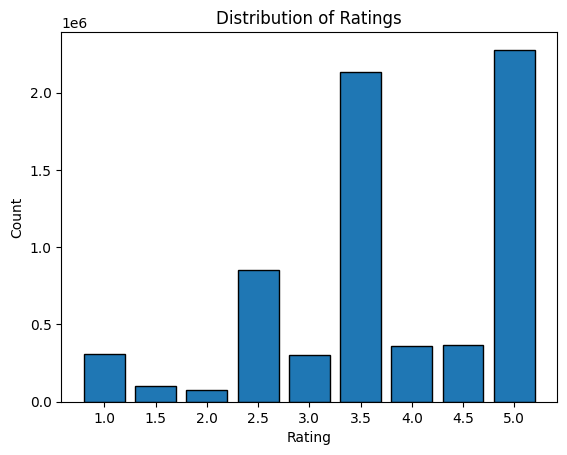

In [ ]:
plot_histogram(ratings_df,
               'rating',
               'counts',
               ratings_df['rating'],
               'Rating',
               'Count',
               'Distribution of Ratings'
               )

Moreover, as it can be saw from the CDF it is possible to say that more or less the 60% of the ratings have a value that is 3.5 or lower

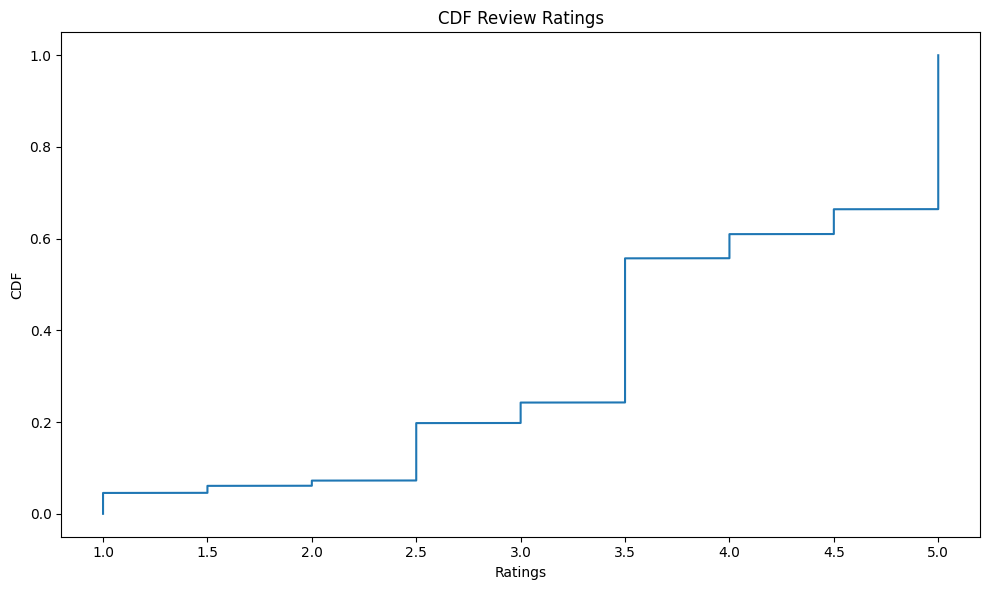

In [ ]:
plot_cdf_with_focus(pd_reviews_df['rating'], 'Ratings', None, None, 'CDF Review Ratings')

As presented from the Box Plot, the majority of the ratings goes from 3.5 to 5.0

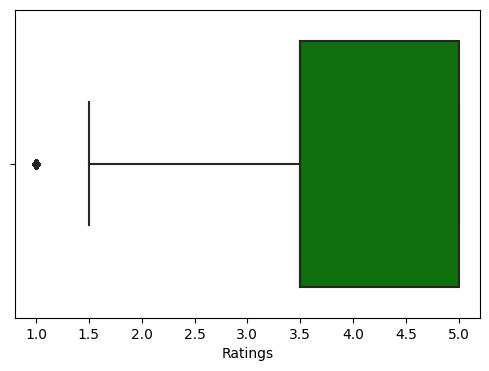

In [ ]:
plot_box_plot(pd_reviews_df.rating, "Ratings")

## Items' popularity EDA
In this section it will be presented the EDA made on the Items' popularity meaning that it will be inspected how many are the most popular (the one with more reviews) videogames in the dataset

In [ ]:
# Group the reviews on the base of the steam_appind meaning and counting them
# meaning that it will be known how many reviews there are for each game
videogames_popularity_df = reviews_df.groupby('steam_appid').count().orderBy('count')

As it can be saw from the summary of the data there are 79966 games in the dataset and the mean of the amount of reviews for each game is 84. Naturaly since there is at least a game with 39433 reviews (while all the other percentiles says that the games have a number of reviews that span from 1 to 32) the standard deviation is really really high

In [ ]:
# Present the summary of the count of the reviews
videogames_popularity_df.select('count').summary().show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            79966|
|   mean|84.77656754120501|
| stddev|484.5537212185353|
|    min|                1|
|    25%|                2|
|    50%|                8|
|    75%|               32|
|    max|            39433|
+-------+-----------------+



In [ ]:
# Translate the dataframe to a Pandas DataFrame to compute easily the plots
pd_videogames_popularity_df = videogames_popularity_df.toPandas()

As it can be saw from the plots pretty much the 75% of the videogames has a number of reviews that span from 1 to 35

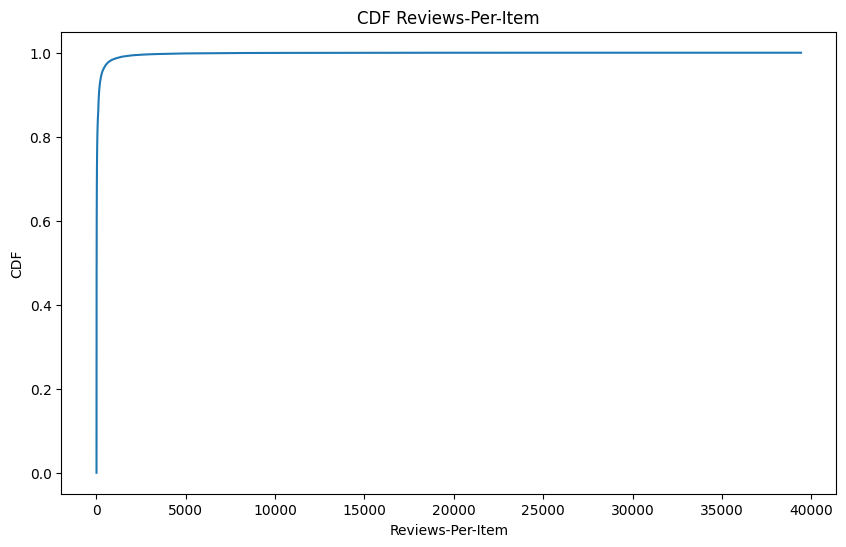

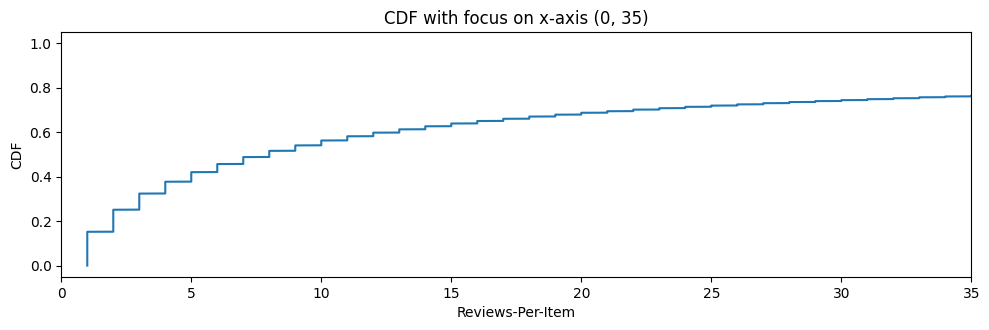

In [ ]:
# Define the ends for the focus on the most significant data
x_min = 0
x_max = 35
plot_cdf_with_focus(pd_videogames_popularity_df['count'], 'Reviews-Per-Item', x_min, x_max, 'CDF Reviews-Per-Item', 'CDF with focus on x-axis ('+str(x_min)+', '+str(x_max)+')' )

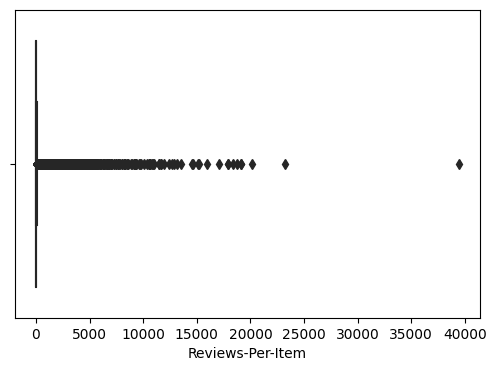

In [ ]:
# QUESTO CONTROLLALO POI SE PUOI O NO METTERLO IN FUNZIONE e vedi pure come leggerlo
fig, ax = plt.subplots(1,1, figsize=(6,4))

#_ = sns.boxplot(x=pd_videogames_popularity_df.count, color="g")
_ = sns.boxplot(x="count", data=pd_videogames_popularity_df, color="g")
_ = ax.set_xlabel("Reviews-Per-Item")

## Users' Activity EDA
In this section it will be presented the EDA made on the Users' Activity, meaning that it will be inspected how many reviews each user left

In [ ]:
# Compute the amount of ratings each user left
ratings_per_user = (
    reviews_df
    .groupBy('steam_id')
    .count()
    .orderBy('count', ascending=False)
)

As it can be saw from the summary of the data, there are 291652 users in the dataset and on average each one of them left 23 reviews. Also in this case, since pretty much all the users left an amount of reviews that span from 1 to 24, but there is also at least one user that left 9296 reviews the standard deviation is really high

In [ ]:
# Compute the summary over the data
ratings_per_user.select('count').summary().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            291652|
|   mean|23.244287712753554|
| stddev| 60.50570284228065|
|    min|                 1|
|    25%|                 3|
|    50%|                 9|
|    75%|                24|
|    max|              9296|
+-------+------------------+



In [ ]:
# Transform the dataframe to a Pandas DataFrame in order to plot easily the plots
pd_ratings_per_user = ratings_per_user.toPandas()

As it can be saw from the CDF more or less the 80% of the users left 35 or less reviews, it is also significant to notice that 60% of the users left 15 or less reviews

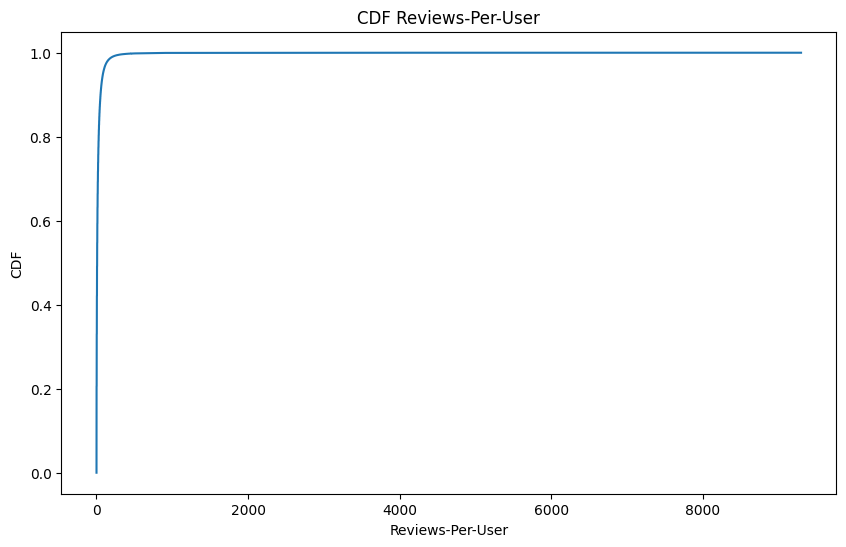

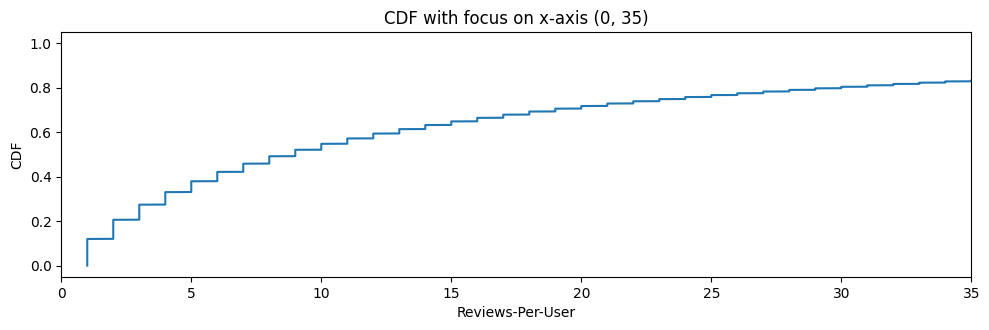

In [ ]:
# Define the ends of the focus of the CDF
x_min = 0
x_max = 35
plot_cdf_with_focus(pd_ratings_per_user['count'], 'Reviews-Per-User', x_min, x_max, 'CDF Reviews-Per-User', 'CDF with focus on x-axis ('+str(x_min)+', '+str(x_max)+')' )

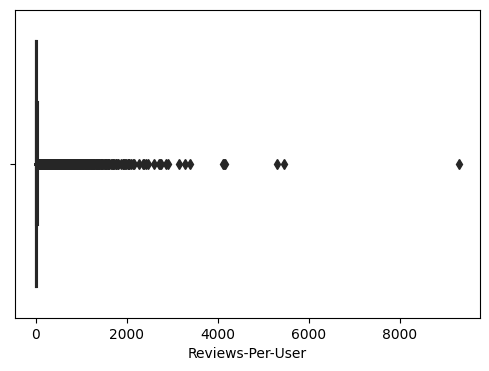

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

#_ = sns.boxplot(x=pd_videogames_popularity_df.count, color="g")
_ = sns.boxplot(x="count", data=pd_ratings_per_user, color="g")
_ = ax.set_xlabel("Reviews-Per-User")

# ALS Training
After analyzing the data it is possible to proceed with the model training in order to create the real Recommender System.

For the sake of this project it has been decided to produce a Collaborative Filtering Recommender System Model Based with ALS (Alternate Least Square): during the job done on the project it has also tried to produce Memory Based Recommender Systems (both User-Based and Item-Based) but due to the limitations in the resoruces (specifically in the RAM) it has not been possible to ever compute a Recommender System in this way.

As better explained later, the ALS model has been trained thanks to a Cross Validation that permitted to produce the better version of the model given the parameters provided in the training

In [ ]:
# Check for the table schema
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- rating: float (nullable = true)



In order to make possible the ALS training it is needed to map the Steam IDs of the users to an Integer version of them

In [ ]:
# Create the mapping between the Long verison of the IDs and the Integer version
# of them
user_id_mapping = reviews_df.select('steam_id').distinct().rdd.zipWithIndex().toDF(['steam_id', 'steam_int_id'])

In [ ]:
# Check the result
user_id_mapping.printSchema()

root
 |-- steam_id: struct (nullable = true)
 |    |-- steam_id: long (nullable = true)
 |-- steam_int_id: long (nullable = true)



Since the mapping created a struct field that must not be in this way in order to have the possibility to join the new table with the old one, it is necessary to select the field of the struct and build a schema that is consistent with the the schema of the other table

In [ ]:
# Get only the needed field of the new table
mapped_ids = user_id_mapping.select(sqlf.col("steam_int_id"), sqlf.col("steam_id").getItem("steam_id").alias("steam_id"))

In [ ]:
# Inspect some rows of the table for the mapping
mapped_ids.show()

+------------+-----------------+
|steam_int_id|         steam_id|
+------------+-----------------+
|           0|76561198259233672|
|           1|76561198341423566|
|           2|76561198031569409|
|           3|76561197972849454|
|           4|76561197973899044|
|           5|76561198076660221|
|           6|76561199196015162|
|           7|76561198148487790|
|           8|76561198130662169|
|           9|76561197962366215|
|          10|76561197960269579|
|          11|76561198153732068|
|          12|76561198045204619|
|          13|76561198054117588|
|          14|76561197972329126|
|          15|76561198031573706|
|          16|76561198115985007|
|          17|76561198132762380|
|          18|76561198290049169|
|          19|76561198036818252|
+------------+-----------------+
only showing top 20 rows



In [ ]:
# Join the two tables
user_activity_df = reviews_df.join(mapped_ids, on='steam_id', how='inner')

In [ ]:
# Inspect a sample of rows
user_activity_df.show()

+-----------------+-----------+---------------+------+------------+
|         steam_id|steam_appid|    recommended|rating|steam_int_id|
+-----------------+-----------+---------------+------+------------+
|76561198259233672|     951650|    Recommended|   3.0|           0|
|76561198341423566|    1581451|    Recommended|   3.0|           1|
|76561198031569409|       2310|    Recommended|   3.5|           2|
|76561198031569409|     337000|    Recommended|   5.0|           2|
|76561198031569409|    1353270|Not Recommended|   2.0|           2|
|76561198031569409|    1049410|Not Recommended|   1.0|           2|
|76561198031569409|     294860|Not Recommended|   2.5|           2|
|76561198031569409|     429660|Not Recommended|   2.5|           2|
|76561198031569409|     224760|Not Recommended|   2.5|           2|
|76561198031569409|     405830|    Recommended|   3.5|           2|
|76561198031569409|      31290|    Recommended|   4.0|           2|
|76561198031569409|      32360|    Recommended| 

In [ ]:
# Save the table with the mapping for future computations
user_activity_df.write.options(header='True', delimiter=',').csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/user_activity')

In order to train and evaluate the performances of the model it is necessary to divide the dataset into two different part: the training dataset, that are the data that will be used during the model training, and the test dataset, that are the data that will be used during the model evaluation.

In order to make the training re-executable the seed has been put to RANDOM_SEED so that the split will happen always in the same way

In [ ]:
# Split the dataset in the training set and the test set
(training, test) = user_activity_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In the following cell the ALS model is created. Specifically the model:


*   Will consider the value in steam_int_id as the users of the system
*   Will consider the value in steam_appid as the item of the system
*   Will consider the value of rating as the ratings given by the users to the items
*   Will set the coldStartStrategy to **drop** in order to have the possibility to evaluate the model



In [ ]:
als = ALS(
    userCol="steam_int_id",
    itemCol="steam_appid",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

In [ ]:
als.checkpointInterval = 2

The *param_grid* is used in order to day which are the hyper-parameter values that must be tested for the hyper-parameters. In this way it will be possible to train the model thanks to a Cross Validator.

It is important to know that:


*   rank express the **number of latent factors that the model will try to learn**
*   maxIter express the **number of iterations to be performed during the matrix factorization**
*   regParam express **how much it is possible to be distant from the right value during the training**



In [ ]:
param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [1, 15, 20])\
             .addGrid(als.maxIter, [10])\
             .addGrid(als.regParam, [.8, .6])\
             .build()

The *evaluator* is used to evaluate the performance of the model.

This specific evaluator will check the RMSE (Root Mean Square Error) computed checking how much the prediction is distant from the actual rating that the user gave to the item

In [ ]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

The *CrossValidator* will then build the models with the wanted values said by the *ParamGrid* and will evaluate them thanks to the *Evaluator*

In [ ]:
cv = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3)

In [ ]:
# Train the possible models over the training set
model = cv.fit(training)

The model that gave the best performance evaluation will be saved in order to be used later

In [ ]:
# Retrieve the best model and present the values for the hyper-parameters
best_model = model.bestModel
print('rank: ', best_model.rank)
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('RegParam: ', best_model._java_obj.parent().getRegParam())

rank:  15
MaxIter:  10
RegParam:  0.6


In [ ]:
# Save the model
path = '/content/gdrive/MyDrive/VideogameRecommenderSystem/models/'
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
model_name = "ALS" + dt_string
path += model_name
best_model.save(path)